In [1]:
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd


Bad key "text.kerning_factor" on line 4 in
C:\Users\sarahwang\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#load dataframe from csv
demographics_data = pd.read_csv("2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
demographics_data = demographics_data.drop(columns=["Geo_ZCTA5", "Geo_ZCTA3", "Geo_LOGRECNO", "Geo_GEOCOMP", "Geo_SUMLEV"])

(33120, 2151)


In [3]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


In [4]:
# drop any column with missing values greater than 5%
demographics_data.drop(columns=["SE_A18007_006","SE_A18007_007","SE_A18007_005","SE_A18007_004",
                     "SE_A18007_003","SE_A18007_002","SE_A18008_011",
                     "SE_A18008_010","SE_A18008_009","SE_A18010_002",
                     "SE_A18010_003","SE_A18010_004","SE_A18010_005",
                     "SE_A18010_006","SE_A18010_007","SE_A18008_001","SE_A18008_002",
                     "SE_A18008_003","SE_A18008_008","SE_A18008_007","SE_A18008_006","SE_A18008_005",
                     "SE_A18008_004"], axis=1, inplace=True)

Ok, maybe all along we've been picking bad datapoints to look at, lets just Gini index, Average household income, and rent as a percentage of income.

C:\Users\sarahwang\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\sarahwang\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\sarahwang\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

SE_A14028_001           948
SE_A14011_001          1662
vacancy_rate            490
income_to_homevalue    2670
renters_pct             490
dtype: int64
(30450, 6)
 clusters:  155  and noise points  2913 , noise as :  0.09566502463054187


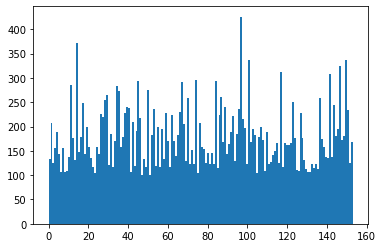

In [5]:

# gini index and average household income
reduced_demos = demographics_data[["zip", "SE_A14028_001", "SE_A14011_001"]]
reduced_demos["vacancy_rate"] = demographics_data["SE_A10001_001"].divide(demographics_data["SE_A10044_002"])
reduced_demos["income_to_homevalue"] = demographics_data["SE_A10036_001"].divide(demographics_data["SE_A14011_001"])
reduced_demos["renters_pct"] = demographics_data["SE_A10060_003"].divide(demographics_data["SE_A10001_001"])

null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
#reduced_demos = StandardScaler().fit_transform(reduced_demos)

reduced_demos_no_zip = reduced_demos.drop("zip", axis=1)

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=3, cluster_selection_method='leaf')
clusterer.fit(reduced_demos_no_zip)

labels = clusterer.labels_
unique_labels = set(labels)
print( " clusters: ", len(unique_labels), " and noise points ", (labels == -1).sum(), ", noise as : ", (labels == -1).sum()/len(labels))

label_sum = []

for k in unique_labels:
    label_sum.append((labels == k).sum())
    
non_noise = labels[labels != -1]

plt.hist(non_noise, bins=len(unique_labels)-1)
plt.show()

In [6]:
clusters = reduced_demos[['zip']]
clusters["cluster"] = labels
clusters.head()

C:\Users\sarahwang\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,zip,cluster
0,601,-1
1,602,-1
2,603,10
3,606,-1
4,610,-1


So using just those statistics we can get some pretty reasonable clusters. Now let's join those up with the sales data.

In [12]:
sales_data = pd.read_csv("test.csv", header = 1)
sales_data.index = sales_data.index.astype(int)
sales_data = sales_data.rename(columns={"Region":"zip"})
#sales_data.set_index('zip', inplace = True)
sales_data = sales_data.fillna(0)
print(sales_data.head())

      zip  01/02/2016  01/03/2016  01/04/2016  01/05/2016  01/06/2016  \
0   501.0        0.00        0.00        0.00        0.00        0.00   
1  1005.0        0.15        0.06       -0.30       -0.24        0.34   
2  1010.0        0.00        0.00        0.00        0.00        0.00   
3  1031.0        7.05        6.12       -0.25       -0.25       -0.83   
4  1037.0        0.00        0.00       -0.24        0.00        1.03   

   01/07/2016  01/08/2016  01/09/2016  01/10/2016  ...  01/12/2019  \
0        0.00        0.00        0.00        0.00  ...        0.00   
1        0.09        0.06       -0.09       -0.04  ...        0.07   
2        0.00        0.00        0.00        0.00  ...        0.00   
3       -0.14       -0.03       -0.02        0.28  ...        0.44   
4        1.50        1.50        0.00        0.00  ...        0.00   

   01/01/2020  01/02/2020  01/03/2020  01/04/2020  01/05/2020  01/06/2020  \
0        0.00        0.00        0.00        0.00        0.00  

Now we get sales data for each of our clusters

In [13]:
cluster_sales = sales_data.merge(clusters, on="zip")
cluster_sales = cluster_sales.fillna(0)
cluster_sales.head()

,zip,01/02/2016,01/03/2016,01/04/2016,01/05/2016,01/06/2016,01/07/2016,01/08/2016,01/09/2016,01/10/2016,...,01/01/2020,01/02/2020,01/03/2020,01/04/2020,01/05/2020,01/06/2020,01/07/2020,01/08/2020,01/09/2020,cluster
0,1005.0,0.15,0.06,-0.30,-0.24,0.34,0.09,0.06,-0.09,-0.04,...,-0.04,0.06,-0.08,0.02,-0.04,0.12,-0.01,0.05,0.01,33
1,1010.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29
2,1031.0,7.05,6.12,-0.25,-0.25,-0.83,-0.14,-0.03,-0.02,0.28,...,-0.14,0.71,1.62,1.27,-0.01,-0.38,-0.48,-0.51,6.81,68
3,1037.0,0.00,0.00,-0.24,0.00,1.03,1.50,1.50,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.24,-0.15,17
4,1057.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29


Now create a dataframe which contains the mean sales data across all months for each zipcode in the cluster

In [71]:
cluster_names = []
mean_yoy_by_cluster = pd.DataFrame()

for c in np.unique(cluster_sales["cluster"]):
    sub = cluster_sales[(cluster_sales['cluster'] == c)]
    sub_no_zip = sub.drop(columns=["cluster", "zip"])
    tmp_df = sub_no_zip.mean(1).to_frame()
    #tmp_df = tmp_df.transpose()
    tmp_df["cluster"] = c
    tmp_df["zip"] = sub["zip"]
    tmp_df.set_index("zip")
    mean_yoy_by_cluster = mean_yoy_by_cluster.append(tmp_df, ignore_index=True)

#we can't do this here because we need it later, but we will set the index to zip before doing the OLS
#mean_yoy_by_cluster = mean_yoy_by_cluster.set_index("zip")

print(mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == 1].head())
mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == 1].shape

             0  cluster     zip
1662  0.036071        1  1451.0
1663  0.041786        1  1742.0
1664  0.053750        1  1748.0
1665  0.010714        1  1770.0
1666  0.055179        1  1772.0


(192, 3)

Now we need to get the demographic data of some selected fields for each cluster

In [72]:

all_cluster_demos = pd.DataFrame()

# we'll just start with 1 to see if it works, can become all later

for c in np.unique(clusters["cluster"]):
    zip_codes_for_cluster = mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == c]
    cluster_demographics = demographics_data[demographics_data['zip'].isin(zip_codes_for_cluster["zip"])]
    cluster_demographics = cluster_demographics[['zip', 'SE_B01001_003','SE_B01001_004', 'SE_A14001_014', 'SE_A14001_015', 'SE_A14001_016', 'SE_A14001_017', 'SE_A00002_002']]
    cluster_demographics.rename(columns = {"SE_B01001_003": "Population_18-34","SE_B01001_004": "Population_35-64","SE_A14001_014":"Income_100-124k","SE_A14001_015":"Income_125-149k","SE_A14001_016":"Income_150-199k","SE_A14001_017":"Income>200k", "SE_A00002_002":"Population_Density"}, inplace = True)
    cluster_demographics["cluster"] = c
    all_cluster_demos = all_cluster_demos.append(cluster_demographics, ignore_index=True)

all_cluster_demos = all_cluster_demos.set_index('zip')
print(all_cluster_demos.head())
all_cluster_demos[all_cluster_demos["cluster"] == 1].shape

      Population_18-34  Population_35-64  Income_100-124k  Income_125-149k  \
zip                                                                          
1440              4684              8685            572.0            389.0   
1463              2324              5310            541.0            586.0   
1467                94               114             12.0              9.0   
1468               907              1788            184.0            129.0   
1475              2386              4283            560.0            374.0   

      Income_150-199k  Income>200k  Population_Density  cluster  
zip                                                              
1440            280.0        270.0            855.2825       -1  
1463            469.0        515.0            535.0845       -1  
1467             11.0         33.0            192.2035       -1  
1468            132.0         89.0            188.0031       -1  
1475            252.0        135.0            252.0099   

(192, 8)

In [73]:
# now use zip as the index for the demographics
mean_yoy_by_cluster = mean_yoy_by_cluster.set_index("zip")

In [74]:
all_cluster_demos[all_cluster_demos["cluster"] == 1]

,Population_18-34,Population_35-64,Income_100-124k,Income_125-149k,Income_150-199k,Income>200k,Population_Density,cluster
zip,,,,,,,,
1451,613,2020,157.0,134.0,229.0,610.0,241.6312,1
1742,2299,8724,652.0,683.0,890.0,2305.0,791.8770,1
1748,2415,8251,500.0,411.0,904.0,2377.0,655.0185,1
1770,332,2056,162.0,136.0,195.0,710.0,272.4182,1
1772,1435,4224,299.0,273.0,520.0,1084.0,697.3028,1
...,...,...,...,...,...,...,...,...
98075,3068,11531,762.0,779.0,1255.0,3225.0,2488.2800,1
98077,1841,7028,656.0,327.0,620.0,1792.0,816.6321,1
98105,29894,9975,1165.0,619.0,1289.0,2613.0,11837.5800,1


In [65]:
import statsmodels.api as sm

X = all_cluster_demos[all_cluster_demos["cluster"] == 1][['Population_18','Population_35-64	', 'Income_100-124k', 'Income_125-149k', 'Income_150-199k', 'Income>200k	','SE_A00002_002']]
Y = mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == 1][0]
# print(X)
# print(Y)

model = sm.OLS(Y, X).fit()
print(model.summary())

all_models = []

for c in np.unique(clusters["cluster"]):
    X = all_cluster_demos[all_cluster_demos["cluster"] == c][['SE_B01001_003','SE_B01001_004',  'SE_A14001_014', 'SE_A14001_015', 'SE_A14001_016', 'SE_A14001_017','SE_A00002_002']]
    Y = mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == c][0]
    model = sm.OLS(Y, X).fit()
    all_models.append({"cluster":c, "model":model})
    


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.215
Model:                            OLS   Adj. R-squared (uncentered):              0.186
Method:                 Least Squares   F-statistic:                              7.258
Date:                Mon, 07 Dec 2020   Prob (F-statistic):                    1.10e-07
Time:                        19:02:58   Log-Likelihood:                          229.77
No. Observations:                 192   AIC:                                     -445.5
Df Residuals:                     185   BIC:                                     -422.7
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [67]:
rsq_adj = []
rsq = []
fstat = []

for m in all_models:
    rsq_adj.append(m["model"].rsquared_adj)
    rsq.append(m["model"].rsquared)
    fstat.append(m["model"].fvalue)
    
print(" our average rsq adjusted across all of our models is", np.average(rsq_adj))
print(" our best rsq adjusted across all of our models is", np.max(rsq_adj))
print(" our average rsq across all of our models is", np.average(rsq))
print(" our best rsq across all of our models is", np.max(rsq))
print(" our average f stat across all of our models is", np.average(fstat))

 our average rsq adjusted across all of our models is 0.10189849417049682
 our best rsq adjusted across all of our models is 0.5420763652035954
 our average rsq across all of our models is 0.19295284609102725
 our best rsq across all of our models is 0.6877793399115423
 our average f stat across all of our models is 2.8714607024510834


In [24]:
np.max(rsq)

0.6076196920230812

In [68]:
best_rsp = np.where(rsq==np.max(rsq))
best_rsp[0][0]

11

In [69]:
all_models[best_rsp[0][0]]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.688
Model:                            OLS   Adj. R-squared (uncentered):              0.542
Method:                 Least Squares   F-statistic:                              4.720
Date:                Mon, 07 Dec 2020   Prob (F-statistic):                     0.00564
Time:                        19:04:49   Log-Likelihood:                          12.255
No. Observations:                  22   AIC:                                     -10.51
Df Residuals:                      15   BIC:                                     -2.874
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SE_B01001_003    -0.0007      0.000     -2.193      0.045      -0.001   -1.83e-05
SE_B01001_004     0.0003   9.46e-05      2.753      0.015    5.88e-05       0.000
SE_A14001_014     0.0068      0.003      2.026      0.061      -0.000       0.014
SE_A14001_015    -0.0044      0.005     -0.940      0.362      -0.015       0.006
SE_A14001_016     0.0167      0.011      1.492      0.156      -0.007       0.040
SE_A14001_017    -0.0086      0.004     -2.292      0.037      -0.017      -0.001
SE_A00002_002     0.0002   8.78e-05      2.366      0.032    2.06e-05       0.000
==============================================================================
Omnibus:                        1.752   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.416   Jarque-Bera (JB):                0.871
Skew:                           0.483   Prob(JB):                        0.647
Kurtosis:                       3.132   Cond. No.                     1.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""